In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
import fitsio as ft
import healpy as hp
import numpy as np


# PATHS to my storage
# mehdi  @ cori
# rezaie @ OU iMac
HOME    = os.getenv('HOME')
USER    = os.getenv('USER')
sys.path.append(HOME + '/github/DESILSS')
dirs    = dict(rezaie='/Volumes/TimeMachine/data/', mehdi='/global/cscratch1/sd/mehdi/')
scratch = dirs[USER]

In [17]:
d = ft.read(scratch + 'eboss/eBOSS_DR7/ELG_hpsyst.density.nside256.eboss22.fits')
for di in d.dtype.names:print('{} '.format(di), end=' ')

hpind  hpra  hpdec  hpgaiastardens  hpebv  hpnobs_g  hpnobs_r  hpnobs_z  hppsfdepth_g  hppsfdepth_r  hppsfdepth_z  hpgaldepth_g  hpgaldepth_r  hpgaldepth_z  hppsfsize_g  hppsfsize_r  hppsfsize_z  hpweight_lin  random_photo  density_photo  NGC  SGC  eboss21  eboss22  eboss23  eboss25  

In [3]:
features = ['hpgaiastardens', 'hpebv'] \
         + [s+'_'+b for s in ['hppsfdepth', 'hpgaldepth', 'hppsfsize'] for b in 'rgz']
print('# phot. maps to be regressed on : \n {}'.format(features))

# phot. maps to be regressed on : 
 ['hpgaiastardens', 'hpebv', 'hppsfdepth_r', 'hppsfdepth_g', 'hppsfdepth_z', 'hpgaldepth_r', 'hpgaldepth_g', 'hpgaldepth_z', 'hppsfsize_r', 'hppsfsize_g', 'hppsfsize_z']


hppsfsize_r is fixed
hppsfsize_g is fixed
hppsfsize_z is fixed
sys hpgaiastardens :  mean :    446.362, std:    98.905
sys hpebv          :  mean :      0.034, std:     0.016
sys hppsfdepth_r   :  mean :   2073.811, std:  1167.782
sys hppsfdepth_g   :  mean :   2643.799, std:  1841.580
sys hppsfdepth_z   :  mean :    236.420, std:   193.237
sys hpgaldepth_r   :  mean :   1130.868, std:   591.094
sys hpgaldepth_g   :  mean :   1666.482, std:  1069.887
sys hpgaldepth_z   :  mean :    116.833, std:    89.619
sys hppsfsize_r    :  mean :      1.263, std:     0.099
sys hppsfsize_g    :  mean :      1.554, std:     0.126
sys hppsfsize_z    :  mean :      1.135, std:     0.085


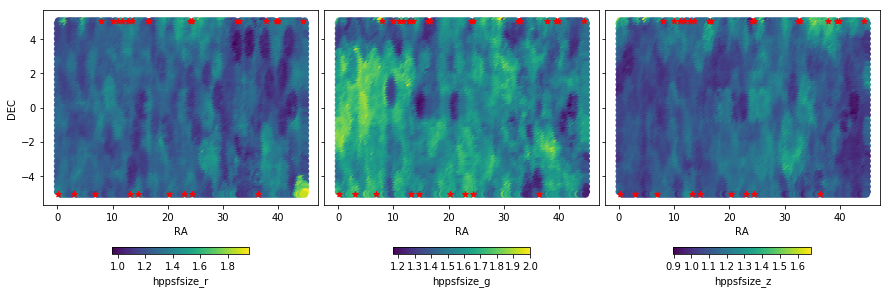

In [5]:
#
# Prepare the data for the NN
#
# eboss MASK
mask     = d['eboss22'].astype('bool')
hpix     = d['hpind'][mask]
label    = d['density_photo'][mask]
data = np.zeros(label.size, dtype=np.dtype([('label', 'f8'), ('features', ('f8',11)),\
                                            ('hpix', 'i8'), ('fracgood', 'f8')]))


Features = []
for f in features:
    Features.append(d[f][mask])
Features = np.column_stack(Features)

# fill in the NaN points
means = np.nanmean(Features, axis=0)
for i in range(Features.shape[1]):
    if (np.isnan(Features[:,i])).sum() !=0:
        print(features[i], 'is fixed')
        nanarg = np.isnan(Features[:,i])
        Features[nanarg, i] = means[i].copy()
        

data['features'] = Features
data['hpix']     = hpix
data['fracgood'] = np.ones_like(hpix)
data['label']    = label

# # Look at the mean and std of features
# #
for m in range(Features.shape[1]):
    print('sys {:15s}:  mean :   {:8.3f}, std:  {:8.3f}'\
          .format(features[m], np.mean(data['features'][:,m]),\
                  np.std(data['features'][:, m])))  

bands= ['r','g', 'z']
f,ax = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)
plt.subplots_adjust(wspace=0.02, top=.9)
for i in range(3):
    name = 'hppsfsize_'+bands[i]    
    masknan = np.isnan(d[name])  & mask
    m1 = ax[i].scatter(d['hpra'][mask], d['hpdec'][mask], c=d[name][mask])
    ax[i].scatter(d['hpra'][masknan], d['hpdec'][masknan], c='red', marker='*')
    cb = f.colorbar(m1, ax=ax[i], shrink=0.5, orientation='horizontal')
    cb.set_label(name)
    ax[i].set_xlabel('RA')
    ax[0].set_ylabel('DEC')    
    
    
# average of labels

# NANmask = np.isnan(d['hppsfsize_r']) & mask
# centers = np.argwhere(NANmask).flatten()
# indices = hp.get_all_neighbours(256, centers)
# for i in range(indices.shape[1]):
#     print(centers[i], np.nanmean(d['hppsfsize_r'][indices[:,i]]))                                


# header=dict(features='hpgaiastardens, hpebv, hppsfdepth, hpgaldepth, hppsfsize  rgz',
#             fracgood='fracgood',  hpix='hpix with nside 256', label='density_photo')
# ft.write(scratch + 'eboss/eBOSS_DR7/ngal.features.256.fits', data, header=header)

# from split_data import split2Kfolds
# data5fold = split2Kfolds(data)
# np.save(scratch + 'eboss/eBOSS_DR7/ngal.features.256.5r', data5fold)
# hp.write_map(scratch + 'eboss/eBOSS_DR7/hpmask.256.fits',   d['eboss22'], fits_IDL=False)
# hp.write_map(scratch + 'eboss/eBOSS_DR7/eBOSSDR7.256.fits', d['density_photo']*d['random_photo'], fits_IDL=False)
# hp.write_map(scratch + 'eboss/eBOSS_DR7/random.256.fits',   d['random_photo'], fits_IDL=False)
# linw = 1/d['hpweight_lin']
# masklinw = (np.isnan(linw) & d['eboss22'])
# linw[masklinw] = 1.0
# hp.write_map(scratch + 'eboss/eBOSS_DR7/regression/lin-weights.hp256.fits',   linw, fits_IDL=False, overwrite=True)

* Run the NN
* Run NNbar

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
d = np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering/eboss22.npy').item()
dw= np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering/eboss22wnn.npy').item()
dl= np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering/eboss22wlin.npy').item()

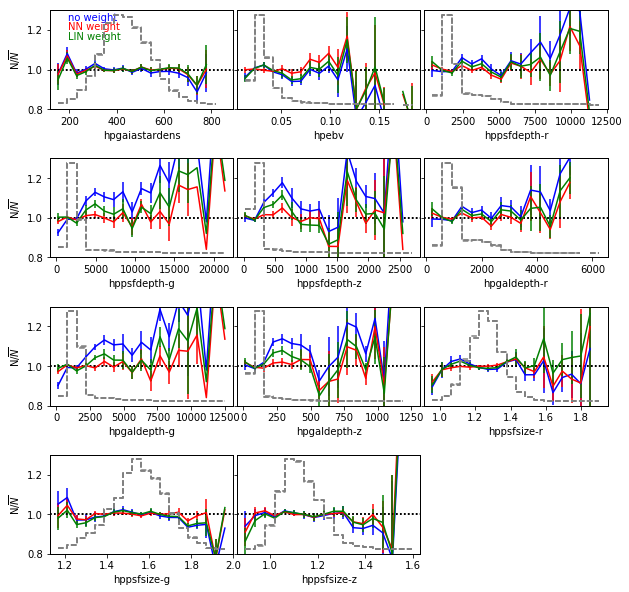

In [6]:
labels = d['xlabels']
fig, ax = plt.subplots(ncols=3, nrows=4, sharey=True, figsize=(10, 10))
plt.subplots_adjust(wspace=0.02, hspace=0.5)
ax = ax.flatten()
fig.delaxes(ax[-1])
def add_ax(ax, res, **kw):
    ax.errorbar(res['bin_edges'][:-1], res['nnbar'],
                  yerr=res['nnbar_err'], **kw)
    ax.axhline(1, linestyle=':', color='k')
    ax2 = ax.twinx()
    ax2.set_yticks([])
    ax2.step(res['bin_edges'][:-1], res['area'],\
            where='post', linestyle='--', color='grey')

#
# compute nnbar vs. systematics
for i in range(len(d['xlabels'])):
    add_ax(ax[i], d['nnbar'][i], color='b')
    add_ax(ax[i], dw['nnbar'][i], color='r')
    add_ax(ax[i], dl['nnbar'][i], color='g')
    if i%3 == 0:ax[i].set_ylabel(r'N/$\overline{N}$')
    ax[i].set_xlabel(labels[i])
    ax[i].set_ylim(0.8, 1.3)
    if i==0:
        ax[i].text(0.1, 0.9, 'no weight', color='b', transform=ax[i].transAxes)
        ax[i].text(0.1, 0.8, 'NN weight', color='r', transform=ax[i].transAxes)
        ax[i].text(0.1, 0.7, 'LIN weight', color='g', transform=ax[i].transAxes)


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
d = np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering/ebossdr7xi_2pc_nside_256_njack_0.npy').item()
dw= np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering/ebossdr7xi_2pc_wnn_nside_256_njack_0.npy').item()
dl= np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering/ebossdr7xi_2pc_wlin_nside_256_njack_0.npy').item()

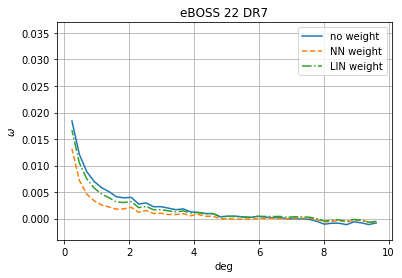

In [15]:
l = ['no weight', 'NN weight', 'LIN weight'] 
ls=['-', '--', '-.']
for i,di in enumerate([d, dw, dl]):
    plt.plot(np.degrees(di['t'][1:]), di['w'][0]/di['w'][1], label=l[i], ls=ls[i])
plt.xlabel('deg')
plt.ylabel(r'$\omega$')
plt.title('eBOSS 22 DR7')
plt.ylim(-0.004, 0.037)
plt.grid()
plt.legend()